In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import *
from scipy.signal import savgol_filter
def myplot():
    plt.rcParams['font.family'] ='Arial'#使用するフォント
    plt.rcParams['xtick.direction'] = 'out'#x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
    plt.rcParams['ytick.direction'] = 'out'#y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
    plt.rcParams['xtick.minor.width'] = .7#x軸主目盛り線の線幅
    plt.rcParams['ytick.minor.width'] = .7#x軸主目盛り線の線幅
    plt.rcParams['xtick.major.width'] = .7#x軸主目盛り線の線幅
    plt.rcParams['ytick.major.width'] = .7#y軸主目盛り線の線幅
    plt.rcParams['font.size'] = 7 #フォントの大きさ
    plt.rcParams['axes.linewidth'] = .7# 軸の線幅edge linewidth。囲みの太さ
    plt.rcParams['figure.figsize'] = [2.5,1.6]# 図のサイズはインチで指定され、変数は(幅, 高さ)です。3.14 インチは約8cm。
    plt.rcParams['figure.dpi'] = 600

myplot()

C:\Users\mikami\AppData\Local\Temp\ipykernel_2980\3876442237.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt.iloc[0] = 0  # 最初の値を0にする


velocity_sg_directの最小値: 0.4335810066667401
最小値の時刻: 32.62199999999988
velocity_sg_directの最大値: 89.8299556719871
最大値の時刻: 54.595519999999865


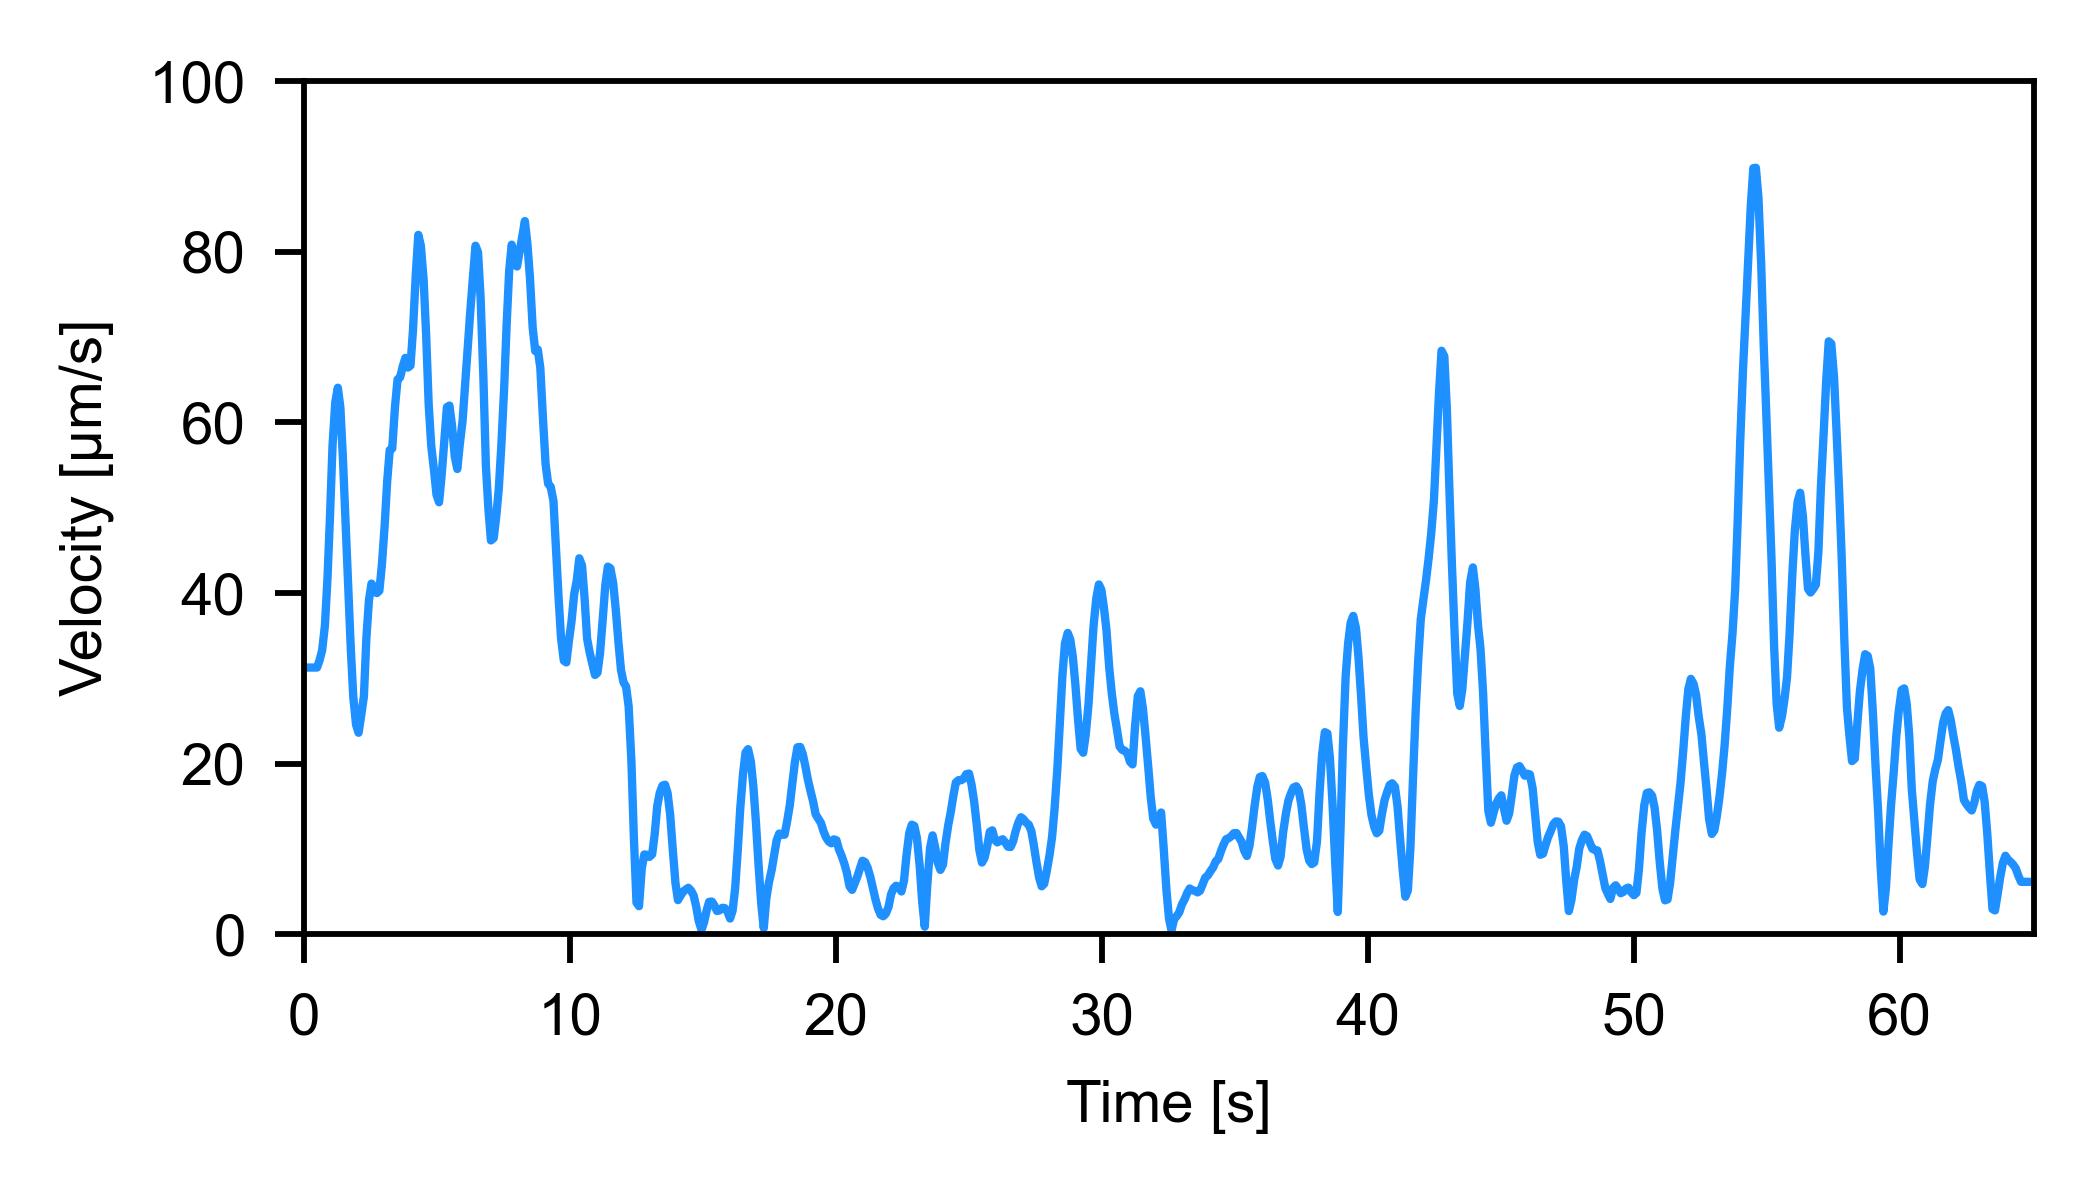

In [5]:

# CSVファイルのパス
csv_path = r"F:\kumamushi_shishido\ana\log matching 10 fps.csv"
save_dir = r"F:\kumamushi_shishido\fig"

# CSVを読み込み（ヘッダーありの場合はheader=0、なければheader=None）
df = pd.read_csv(csv_path, encoding="shift_jis")

# C列（stageX[pulse]）とD列（stageY[pulse]）、E列（Δt [s]）を取得（0始まりなのでC=2, D=3, E=4）
stageX = df.iloc[:, 2]
stageY = df.iloc[:, 3]
dt = df.iloc[:, 4]
dt_mean = np.mean(dt)    # サンプリング間隔（平均値で近似）

window_length=11
polyorder=1

# Savitzky-Golayフィルタでローパス
stageX_sg = savgol_filter(stageX, window_length=window_length, polyorder=1, mode='interp')
stageY_sg = savgol_filter(stageY, window_length=window_length, polyorder=1, mode='interp')
PulsetoMicro = 0.01590033

# 速度（1階微分）をSGフィルタで直接計算
stageX_sg_v = savgol_filter(stageX, window_length=window_length, polyorder=polyorder, deriv=1, delta=dt_mean, mode='interp')
stageY_sg_v = savgol_filter(stageY, window_length=window_length, polyorder=polyorder, deriv=1, delta=dt_mean, mode='interp')

# μm/sに変換
stageX_sg_v_um = stageX_sg_v * PulsetoMicro
stageY_sg_v_um = stageY_sg_v * PulsetoMicro

# 合成速度
velocity_sg_direct = np.sqrt(stageX_sg_v_um**2 + stageY_sg_v_um**2)

stageX_um = stageX * PulsetoMicro
stageY_um = stageY * PulsetoMicro
stageX_sg_um = stageX_sg * PulsetoMicro
stageY_sg_um = stageY_sg * PulsetoMicro

# 原点からの距離（ノイズあり/フィルタあり）
distance_raw = np.sqrt(stageX_um**2 + stageY_um**2)
distance_filt = np.sqrt(stageX_sg_um**2 + stageY_sg_um**2)

# 速度計算（フィルタなし）
delta_stageX_raw = np.diff(stageX)
delta_stageY_raw = np.diff(stageY)
delta_d_raw = np.sqrt((delta_stageX_raw * PulsetoMicro) ** 2 + (delta_stageY_raw * PulsetoMicro) ** 2)
dt_valid = dt.iloc[1:].values
velocity_raw = delta_d_raw / dt_valid

# 速度計算（フィルタあり）
delta_stageX = np.diff(stageX_sg)
delta_stageY = np.diff(stageY_sg)
delta_d = np.sqrt((delta_stageX * PulsetoMicro) ** 2 + (delta_stageY * PulsetoMicro) ** 2)
velocity_sg = delta_d / dt_valid

dt.iloc[0] = 0  # 最初の値を0にする
t = dt.iloc[1:].cumsum()
t_full = dt.cumsum()

print("velocity_sg_directの最小値:", velocity_sg_direct.min())
print("最小値の時刻:", t_full[np.argmin(velocity_sg_direct)])
print("velocity_sg_directの最大値:", velocity_sg_direct.max())
print("最大値の時刻:", t_full[np.argmax(velocity_sg_direct)])


plt.figure(figsize=[3.5,2])
# plt.plot(t, velocity_raw, color='cyan', label='Without filter', linewidth=1.5)
# plt.plot(t, velocity_sg, color='magenta', label=f'SG filtered (window={window_length}, poly={polyorder})', linewidth=1.5)
# plt.plot(t_full, velocity_sg_direct, label='SG direct diff (velocity)', color='blue', linewidth=3)
plt.plot(t_full, velocity_sg_direct, color='dodgerblue', linewidth=1)
plt.xlabel('Time [s]')
plt.ylabel('Velocity [μm/s]')
plt.xlim(0, t.iloc[-1])  # ←ここでx軸範囲を指定
plt.ylim(0, 100)  # ←ここでx軸範囲を指定
# plt.xlim(0, 200)  # ←ここでx軸範囲を指定
# plt.legend(frameon=False)
plt.tight_layout()
save_path = os.path.join(save_dir, "velocity_timetrace.tiff")
plt.savefig(save_path, dpi=600)

output_df = pd.DataFrame({'Time [s]': t_full, 'Velocity [μm/s]': velocity_sg_direct})
output_csv_path = os.path.join(save_dir, "time_velocity.csv")
output_df.to_csv(output_csv_path, index=False, encoding="utf-8-sig")

# plt.figure(figsize=[3,3])
# plt.plot(t, velocity_raw, color='cyan', label='Without filter', linewidth=1.5)
# plt.plot(t, velocity_sg, color='magenta', label=f'SG filtered (window={window_length}, poly={polyorder})', linewidth=1.5)
# plt.plot(t_full, velocity_sg_direct, label='SG direct diff (velocity)', color='blue', linewidth=3)
# plt.xlabel('Time [s]')
# plt.ylabel('Velocity [μm/s]')
# plt.ylim(0, 350)  # ←ここでx軸範囲を指定
# plt.xlim(30, 31)  # ←ここでx軸範囲を指定
# plt.legend(frameon=False)
# plt.tight_layout()
# plt.show()

# # 位置座標プロット
# plt.figure(figsize=[6,3])
# plt.plot(t_full, stageX, color='cyan', label='stageX raw', linewidth=1.5)
# plt.plot(t_full, stageX_sg, color='magenta', label='stageX SG filtered', linewidth=1,alpha=0.9)
# plt.plot(t_full, stageY, color='blue', label='stageY raw', linewidth=1.5)
# plt.plot(t_full, stageY_sg, color='red', label='stageY SG filtered', linewidth=1, alpha=0.9)
# plt.xlabel('Time [s]')
# plt.ylabel('Stage position [pulse]')
# plt.legend(frameon=False)
# plt.tight_layout()
# plt.show()

# plt.figure(figsize=[20,2])
# plt.plot(t_full, distance_raw, color='cyan', label='Distance raw', linewidth=1.5)
# plt.plot(t_full, distance_filt, color='magenta', label='Distance filtered', linewidth=1, alpha=0.5)
# plt.xlabel('Time [s]')
# plt.ylabel('Distance from origin [μm]')
# plt.legend(frameon=False)
# plt.tight_layout()
# plt.show()

# plt.figure(figsize=[3,3])
# plt.plot(t_full, distance_raw, color='cyan', label='Distance raw', linewidth=1.5)
# plt.plot(t_full, distance_filt, color='magenta', label='Distance filtered', linewidth=1, alpha=0.5)
# plt.xlabel('Time [s]')
# plt.ylabel('Distance from origin [μm]')
# plt.ylim(3400, 3500)  # ←ここでx軸範囲を指定
# plt.xlim(30, 31)  # ←ここでx軸範囲を指定
# plt.legend(frameon=False)
# plt.tight_layout()
# plt.show()


Velocity histogram (Freedman–Diaconis)

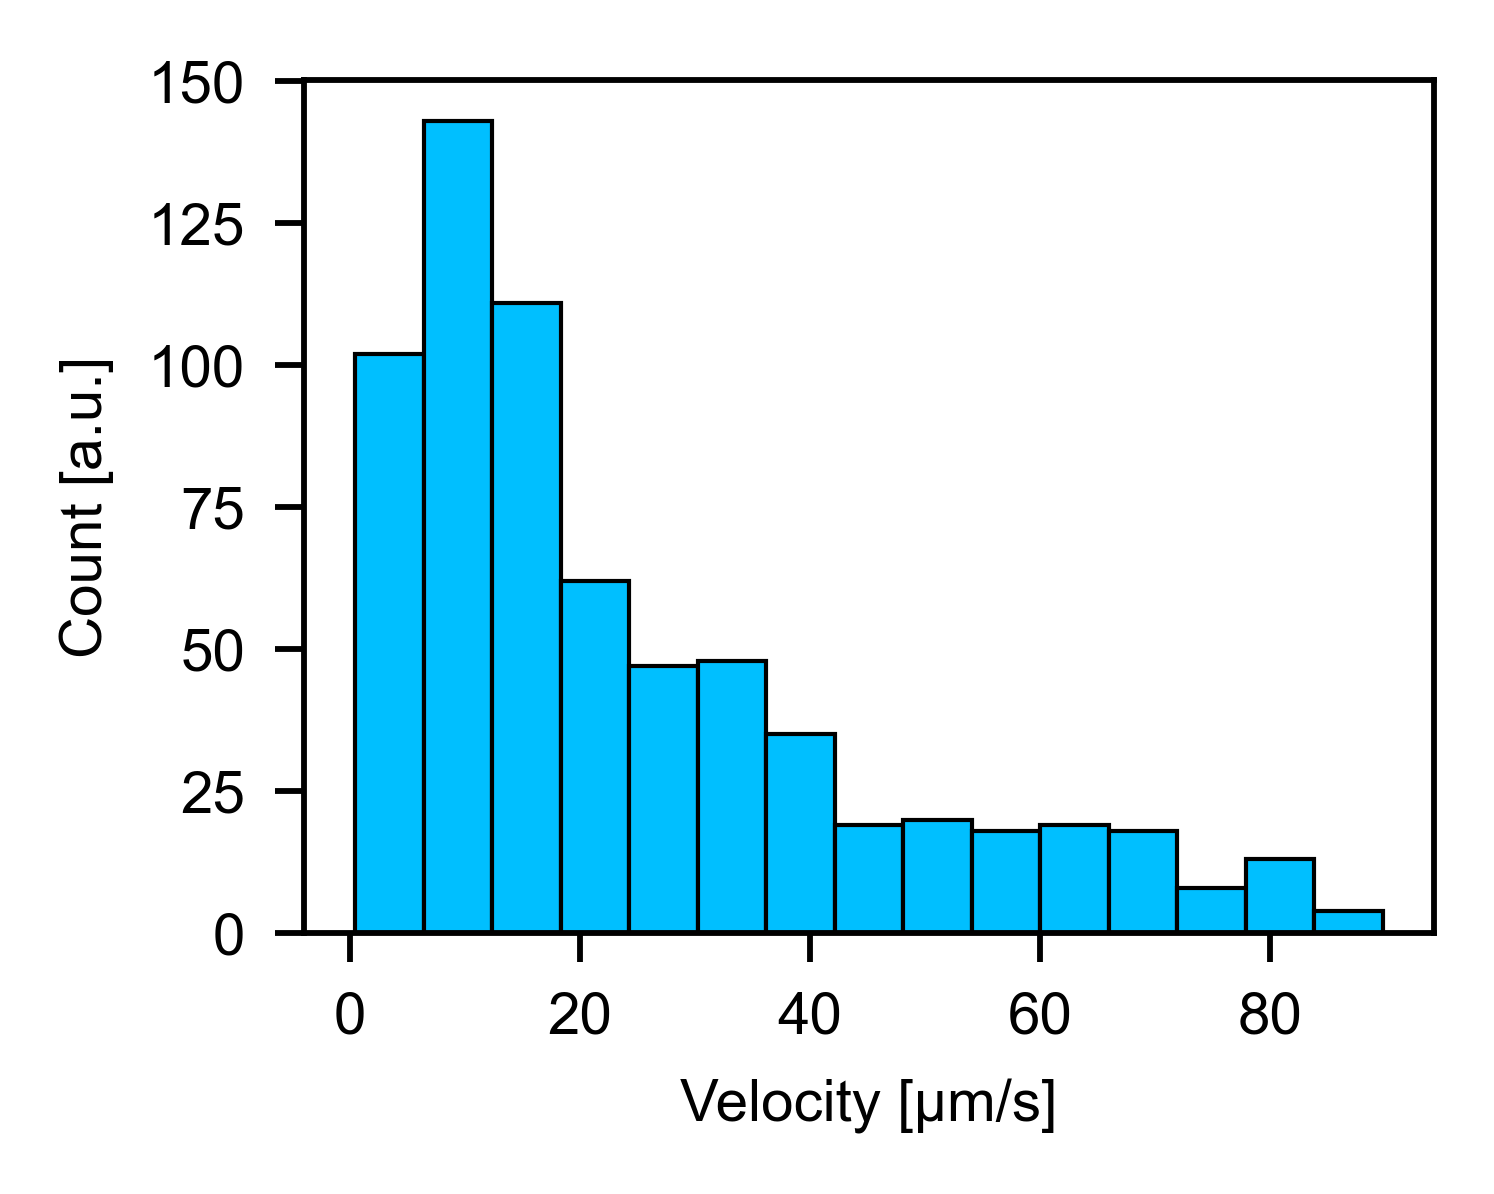

In [6]:
# Freedman–Diaconis
q75, q25 = np.percentile(velocity_sg_direct, [75, 25])
iqr = q75 - q25
n = len(velocity_sg_direct)
bin_width_fd = 2 * iqr * n ** (-1/3)
num_bins_fd = int((velocity_sg_direct.max() - velocity_sg_direct.min()) / bin_width_fd)
num_bins_fd = max(num_bins_fd, 1)
plt.figure(figsize=[2.5, 2])
plt.hist(velocity_sg_direct, bins=num_bins_fd, color='deepskyblue', edgecolor='black', linewidth=.5)
plt.xlabel('Velocity [μm/s]')
plt.ylabel('Count [a.u.]')
plt.tight_layout()
save_path = os.path.join(save_dir, "velocity_histogram.tiff")
plt.savefig(save_path, dpi=600)
counts, bin_edges = np.histogram(velocity_sg_direct, bins=num_bins_fd)
hist_df = pd.DataFrame({
    'Velocity [μm/s]': bin_edges[:-1],
    'Count': counts
})
hist_csv_path = os.path.join(save_dir, "velocity_histogram.csv")
hist_df.to_csv(hist_csv_path, index=False, encoding="utf-8-sig")


Display of movement trajectory

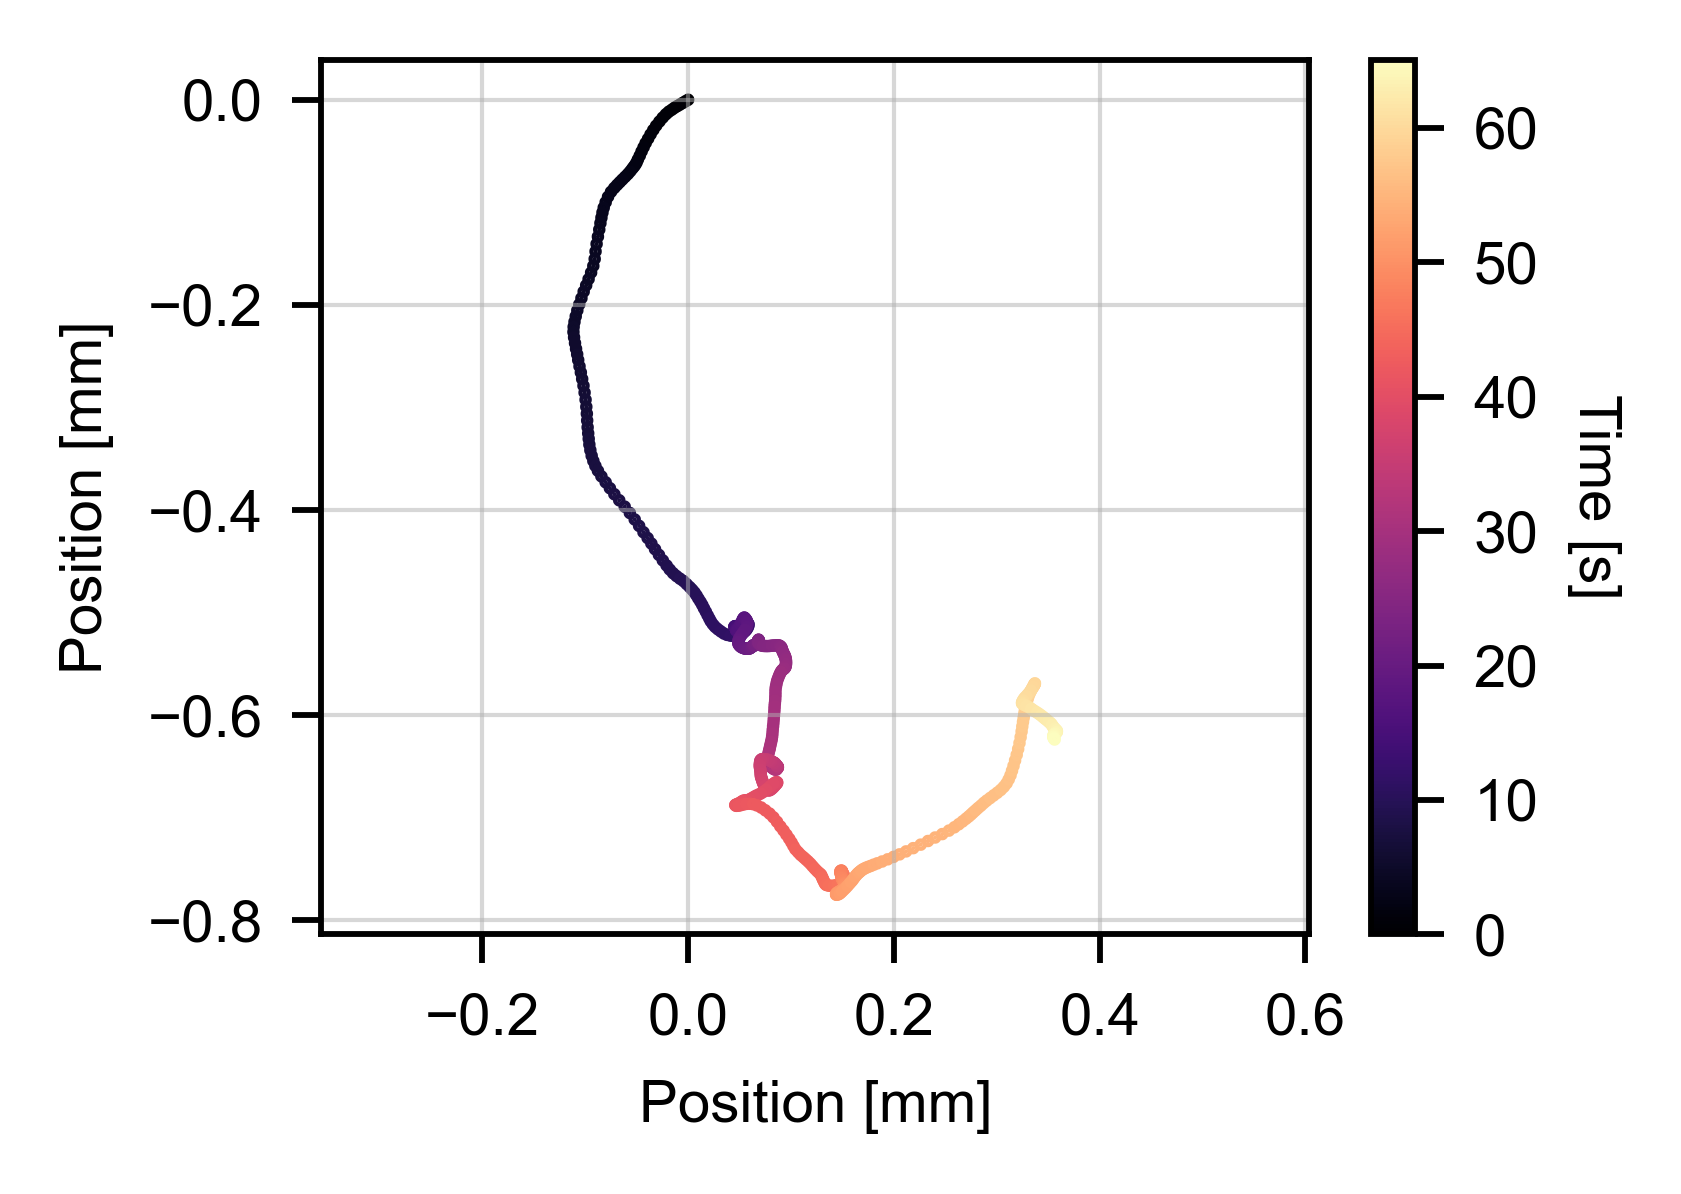

In [8]:
# 原点を初期位置に設定
origin_x = stageX_sg_um[0]
origin_y = stageY_sg_um[0]
# 原点からの相対位置を計算
relative_x = origin_x - stageX_sg_um
relative_y = origin_y - stageY_sg_um
colors = plt.cm.viridis(np.linspace(0, 1, len(t_full)))

plt.figure(figsize=(2.8, 2))
scatter = plt.scatter(relative_x*1e-3, relative_y*1e-3, c=t_full, cmap='magma', marker='.', s=1, alpha=1)
plt.xlabel('Position [mm]')
plt.ylabel('Position [mm]')
# plt.xlim(right=6.5)
cbar = plt.colorbar(scatter)
cbar.set_label('Time [s]', rotation=-90, labelpad=10)
plt.grid(linestyle='-', linewidth=0.5, alpha=0.5, zorder=0)
plt.axis('equal')  # スケールを揃える
plt.tight_layout()
save_path = os.path.join(save_dir, "tracks.tiff")
plt.savefig(save_path, dpi=600)

output_track_df = pd.DataFrame({
    'Time [s]': t_full,
    'Relative X [mm]': relative_x*1e-3,
    'Relative Y [mm]': relative_y*1e-3
})
output_track_csv_path = os.path.join(save_dir, "tracks.csv")
output_track_df.to_csv(output_track_csv_path, index=False, encoding="utf-8-sig")

In [ ]:
from scipy.signal import savgol_coeffs

# SGフィルタの係数（カーネル）を取得
coeffs = savgol_coeffs(window_length, polyorder)

# 周波数応答（FFT）
freq_response = np.abs(np.fft.fft(coeffs, 4096))
freqs = np.fft.fftfreq(4096, d=dt_mean)  # サンプリング間隔dtを指定

# 正の周波数成分のみ表示（Hz単位）
plt.figure(figsize=(6,3))
plt.plot(freqs[:2048], freq_response[:2048])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.title(f'SG filter frequency response\n(window={window_length}, poly={polyorder})')
plt.grid()
plt.tight_layout()
plt.show()